## Import the needed libraries

In [1]:
import PicSureHpdsLib
import pandas
import matplotlib

## Create an instance of the datasource adapter and get a reference to the data resource 

In [2]:
adapter = PicSureHpdsLib.BypassAdapter("http://pic-sure-hpds-nhanes:8080/PIC-SURE")
resource = adapter.useResource()

## Get a listing of all "demographics" entries in the data dictionary. Show what actions can be done with the "demographic_results" object

In [3]:
demographic_entries = resource.dictionary().find("\\demographics\\")
demographic_entries.help()


        [HELP] PicSureHpdsLib.Client(connection).useResource(uuid).dictionary().find(term)
            .count()        Returns the number of entries in the dictionary that match the given term
            .keys()         Return the keys of the matching entries
            .entries()      Return a list of matching dictionary entries
            .DataFrame()    Return the entries in a Pandas-compatible format
             
        [Examples]
            results = PicSureHpdsLib.Client(connection).useResource(uuid).dictionary().find("asthma")
            df = results.DataFrame()
        


## Examine the demographic_entries results by converting it into a pandas DataFrame

In [4]:
demographic_entries.DataFrame()

categorical  observationCount  min        max  \
\demographics\SDDSRVYR\         False             41474  1.0       4.00   
\demographics\INDFMPIR\         False             38076  0.0       5.00   
\demographics\SES_LEVEL\        False             38076  0.0       2.00   
\demographics\SEX\               True             41474  NaN        NaN   
\demographics\DMDBORN\          False             41445  1.0       3.00   
\demographics\WTMEC4YR\         False             21004  0.0  103831.17   
\demographics\DMDMARTL\         False             26793  1.0      99.00   
\demographics\AGE\              False             41474  0.0      85.00   
\demographics\SDMVPSU\          False             41474  1.0       3.00   
\demographics\RACE\              True             41474  NaN        NaN   
\demographics\WTMEC2YR\         False             41474  0.0  261361.34   
\demographics\SDMVSTRA\         False             41474  1.0      58.00   
\demographics\education\        False             34260  0.0       2.00   
\demographics\area\              True             41474  NaN        NaN   

                                                             categoryValues  
\demographics\SDDSRVYR\                                                None  
\demographics\INDFMPIR\                                                None  
\demographics\SES_LEVEL\                                               None  
\demographics\SEX\                                           [female, male]  
\demographics\DMDBORN\                                                 None  
\demographics\WTMEC4YR\                                                None  
\demographics\DMDMARTL\                                                None  
\demographics\AGE\                                                     None  
\demographics\SDMVPSU\                                                 None  
\demographics\RACE\          [black, mexican, other, other_hispanic, white]  
\demographics\WTMEC2YR\                                                None  
\demographics\SDMVSTRA\                                                None  
\demographics\education\                                               None  
\demographics\area\       [1_1, 1_10, 1_11, 1_12, 1_13, 1_14, 1_15, 1_16...

In [56]:
resource.query().help()


        .select()   list of data fields to return from resource for each record
        .require()  list of data fields that must be present in all returned records
        .filter()   list of data fields and conditions that returned records satisfy
                  [ Filter keys exert an AND relationship on returned records      ]
                  [ Categorical values have an OR relationship on their key        ]
                  [ Numerical Ranges are inclusive of their start and end points   ]

        .getCount()             returns a count indicating the number of matching numbers
        .getResults()           returns a CSV-like string containing the matching records
        .getResultsDataFrame()  returns a pandas DataFrame containing the matching records
        .getRunDetails()        returns details about the last run of the query
        .getQueryCommand()      returns the JSON-formatted query request
        .show()                 lists all current query parameters
  

In [57]:
resource.query().filter().help()


            filter().
              add("key", value)                  - or -
              add("key", "value")               filter to records with KEY column that equals VALUE
              add("key", ["value1", "value2"])  filter to records with KEY column equalling one value within the given list
              add("key", start, end)            filter to records with KEY column value between START and END (inclusive)
                                                    start -or- end may be set to None to filter by a max or min value
              delete("key")                     delete a filter from the list of filters
              show()                            lists all current filters that results records must satisfy
              clear()                           clears all values from the filters list
            


In [5]:
query_male = resource.query()
query_male.filter().add("\\demographics\\SEX\\", ["male"])

query_female = resource.query()
query_female.filter().add("\\demographics\\SEX\\", ["female"])

In [6]:
field_age = resource.dictionary().find("\\AGE\\")
field_BMI = resource.dictionary().find("\\Body Mass Index")

query_male.require().add(field_age.keys())
query_male.require().add(field_BMI.keys())
query_female.require().add(field_age.keys())
query_female.require().add(field_BMI.keys())

query_female.show()

.__________[ Query.Select()  has NO SELECTIONS ]____________________________________________________________________________________________________________
.__________[ Query.Require() Settings ]_________________________________________________________________________________________
| _key__________________________________________________________________________________________________________________________
|  \\demographics\\AGE\\                                                                                                            |
|  \\examination\\body measures\\Body Mass Index (kg per m**2)\\                                                                    |
.__________[ Query.Filter()  Settings ]_____________________________________________________________________________________________________________________
| _restriction_type_ | _key__________________________________________________________________________________________________________ | _restriction_values_
|  

## Convert the query results for females into a DataFrame and plot it by BMI and Age

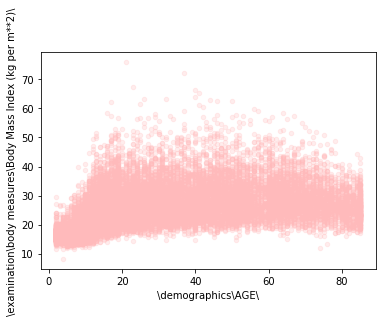

In [8]:
df_f = query_female.getResultsDataFrame()
plot_f = df_f.plot.scatter(x="\\demographics\\AGE\\", y="\\examination\\body measures\\Body Mass Index (kg per m**2)\\", c="#ffbabb40")

## Convert the query results for males into a DataFrame and plot it by BMI and Age

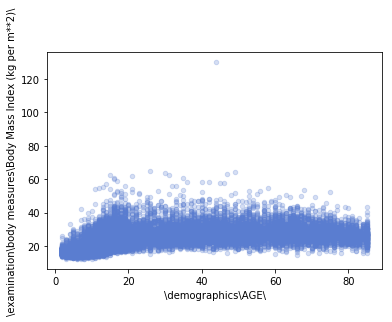

In [9]:
df_m = query_male.getResultsDataFrame()
plot_m = df_m.plot.scatter(x="\\demographics\\AGE\\", y="\\examination\\body measures\\Body Mass Index (kg per m**2)\\", c="#5a7dd040")

## Replot the results using a single DataFrame containing both male and female

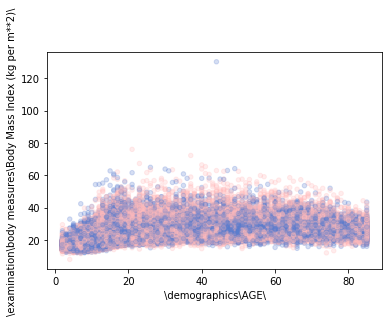

In [10]:
d = resource.dictionary()
criteria = []
criteria.extend(d.find("\\SEX\\").keys())
criteria.extend(d.find("\\Body Mass Index").keys())
criteria.extend(d.find("\\AGE\\").keys())

query_unified = resource.query()
query_unified.require().add(criteria)
df_mf = query_unified.getResultsDataFrame()

# map a color field for the plot to use
sex_colors = {'male':'#5a7dd040', 'female':'#ffbabb40'}
df_mf['\\sex_color\\'] = df_mf['\\demographics\\SEX\\'].map(sex_colors)


# plot data
plot_mf = df_mf.plot.scatter(x="\\demographics\\AGE\\", y="\\examination\\body measures\\Body Mass Index (kg per m**2)\\", c=df_mf['\\sex_color\\'])

## Replot data but trim outliers

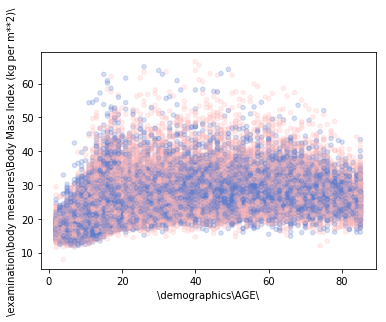

In [11]:
q = df_mf["\\examination\\body measures\\Body Mass Index (kg per m**2)\\"].quantile(0.9999)

# create a masked array to remove outliers
test = df_mf.mask(df_mf["\\examination\\body measures\\Body Mass Index (kg per m**2)\\"] > q)

# plot data
plot_mf = test.plot.scatter(x="\\demographics\\AGE\\", y="\\examination\\body measures\\Body Mass Index (kg per m**2)\\", c=df_mf['\\sex_color\\'])